# Explainable Threshold Similarity (ETS) Tutorial

This notebook demonstrates how to use the Explainable Threshold Similarity (ETS) clustering algorithm for transparent, dimension-wise cluster analysis.

## What is ETS?

Explainable Threshold Similarity (ETS) is a clustering approach described in the paper "???". It provides several advantages over traditional clustering methods:

1. **Dimension-wise interpretability**: Each dimension has its own threshold that determines similarity
2. **Explicit bounds on membership**: Clear criteria for when points belong to the same cluster
3. **Compatibility with heterogeneous feature scales**: Works well with dimensions of vastly different scales
4. **Transparent explanations**: Can explain exactly why two points are in the same or different clusters

ETS declares two activations similar if $|a^l_{i,j} - a^l_{k,j}| \leq \tau_j$ for every dimension $j$. Cluster membership can therefore be verbalized as "neuron j differs by less than $\tau_j$."

Let's begin by importing the necessary libraries and modules.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sys
import os

# Add parent directory to path for imports
sys.path.append('../..')

# Import ETS functions
from concept_fragmentation.metrics.explainable_threshold_similarity import (
    compute_ets_clustering,
    compute_dimension_thresholds,
    explain_ets_similarity,
    compute_ets_statistics
)

# Set up plotting
#plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

## 1. Basic ETS Clustering Example

Let's start with a simple 2D example to visualize how ETS clustering works. We'll create a synthetic dataset with clear clusters.

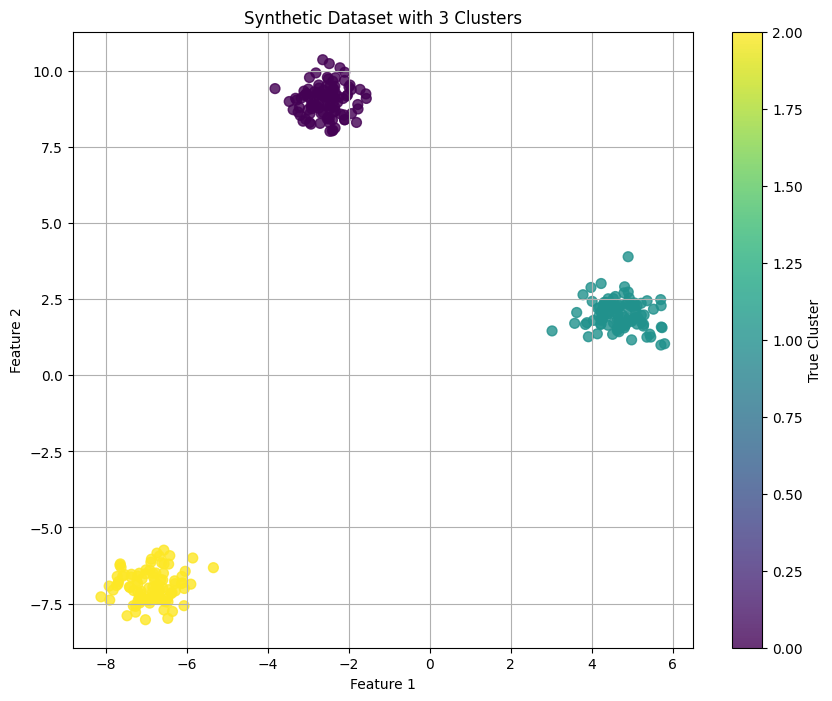

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with 3 clusters
def generate_synthetic_data(n_samples=300, n_clusters=3, n_features=2, cluster_std=0.5):
    # Generate cluster centers
    centers = np.random.uniform(-10, 10, (n_clusters, n_features))
    
    # Ensure centers are well-separated
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            while np.linalg.norm(centers[i] - centers[j]) < 7.0:
                centers[j] = np.random.uniform(-10, 10, n_features)
    
    # Generate data points
    X = np.zeros((n_samples, n_features))
    y = np.zeros(n_samples, dtype=int)
    
    samples_per_cluster = n_samples // n_clusters
    for i in range(n_clusters):
        start_idx = i * samples_per_cluster
        end_idx = (i + 1) * samples_per_cluster if i < n_clusters - 1 else n_samples
        
        # Generate points around cluster center
        X[start_idx:end_idx] = centers[i] + np.random.normal(0, cluster_std, (end_idx - start_idx, n_features))
        y[start_idx:end_idx] = i
    
    return X, y

# Generate data
X, y_true = generate_synthetic_data(n_samples=300, n_clusters=3, n_features=2, cluster_std=0.5)

# Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.8, s=50)
plt.title('Synthetic Dataset with 3 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='True Cluster')
plt.grid(True)
plt.show()

### 1.1 Running ETS Clustering

Now, let's apply ETS clustering to this dataset and visualize the results.

Computing dimension thresholds...
Using thresholds with mean: 0.26810, min: 0.26788, max: 0.26831
Computing similarity matrix for 300 samples with batch size 1000
Similarity matrix computation completed in 0.01s
Finding connected components...
Found 15 clusters
Cluster sizes: min=1, max=98, mean=20.0
Number of clusters found by ETS: 15
Computed thresholds: [0.26830978 0.26788351]


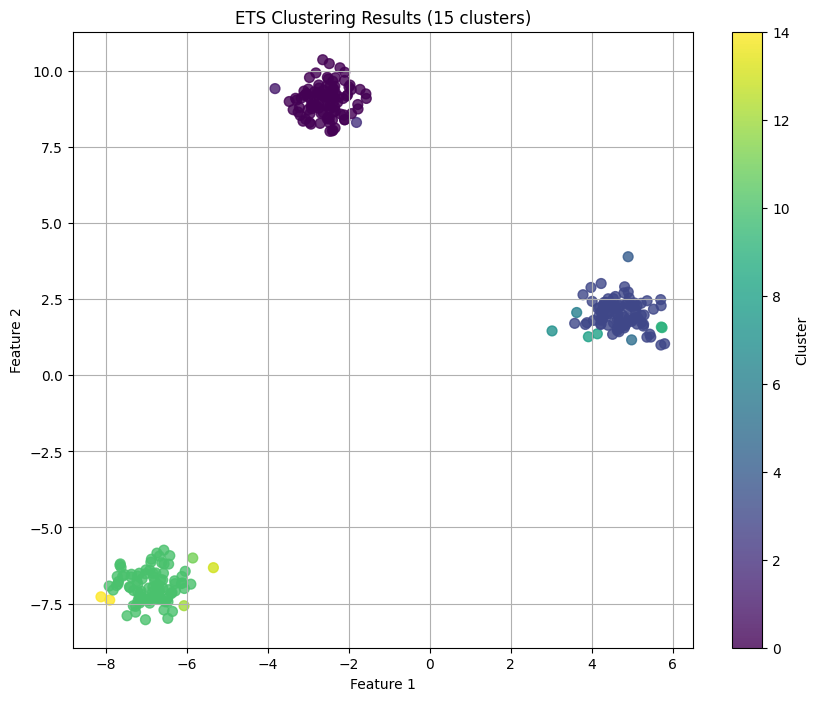

In [6]:
# Run ETS clustering
threshold_percentile = 0.1  # Use 10th percentile of pairwise differences as threshold
ets_labels, thresholds = compute_ets_clustering(
    X,
    threshold_percentile=threshold_percentile,
    verbose=True
)

# Calculate number of clusters found
n_clusters_ets = len(np.unique(ets_labels))
print(f"Number of clusters found by ETS: {n_clusters_ets}")
print(f"Computed thresholds: {thresholds}")

# Plot ETS clustering results
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=ets_labels, cmap='viridis', alpha=0.8, s=50)
plt.title(f'ETS Clustering Results ({n_clusters_ets} clusters)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

### 1.2 Comparing with K-means

Let's compare the ETS results with traditional k-means clustering.

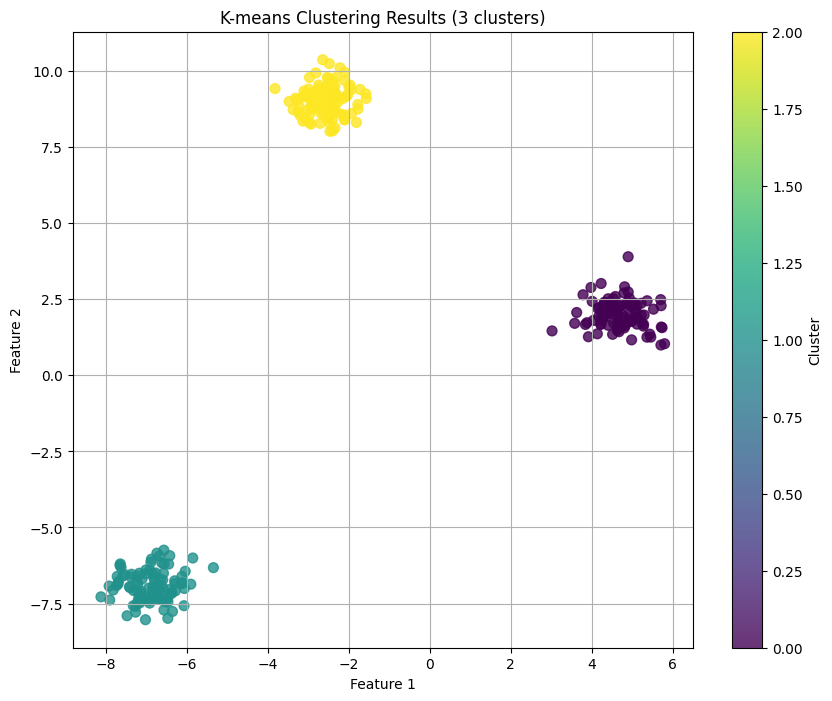

ETS Silhouette Score: 0.032
K-means Silhouette Score: 0.924


ETS Adjusted Rand Index (vs true labels): 0.926
K-means Adjusted Rand Index (vs true labels): 1.000


In [7]:
# Run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Plot k-means clustering results
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.8, s=50)
plt.title('K-means Clustering Results (3 clusters)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Compare clustering metrics
if n_clusters_ets > 1 and len(np.unique(kmeans_labels)) > 1:
    silhouette_ets = silhouette_score(X, ets_labels)
    silhouette_kmeans = silhouette_score(X, kmeans_labels)
    
    ari_ets = adjusted_rand_score(y_true, ets_labels)
    ari_kmeans = adjusted_rand_score(y_true, kmeans_labels)
    
    print(f"ETS Silhouette Score: {silhouette_ets:.3f}")
    print(f"K-means Silhouette Score: {silhouette_kmeans:.3f}")
    print("\n")
    print(f"ETS Adjusted Rand Index (vs true labels): {ari_ets:.3f}")
    print(f"K-means Adjusted Rand Index (vs true labels): {ari_kmeans:.3f}")

## 2. Understanding ETS Thresholds

One of the key features of ETS is its dimension-specific thresholds. Let's explore how these thresholds work and how they affect clustering results.

Dimension-wise Thresholds:


,Feature,Absolute Threshold,Relative Threshold (%),Data Range
0,Feature 1,0.268310,1.928530,13.912658
1,Feature 2,0.267884,1.455458,18.405441


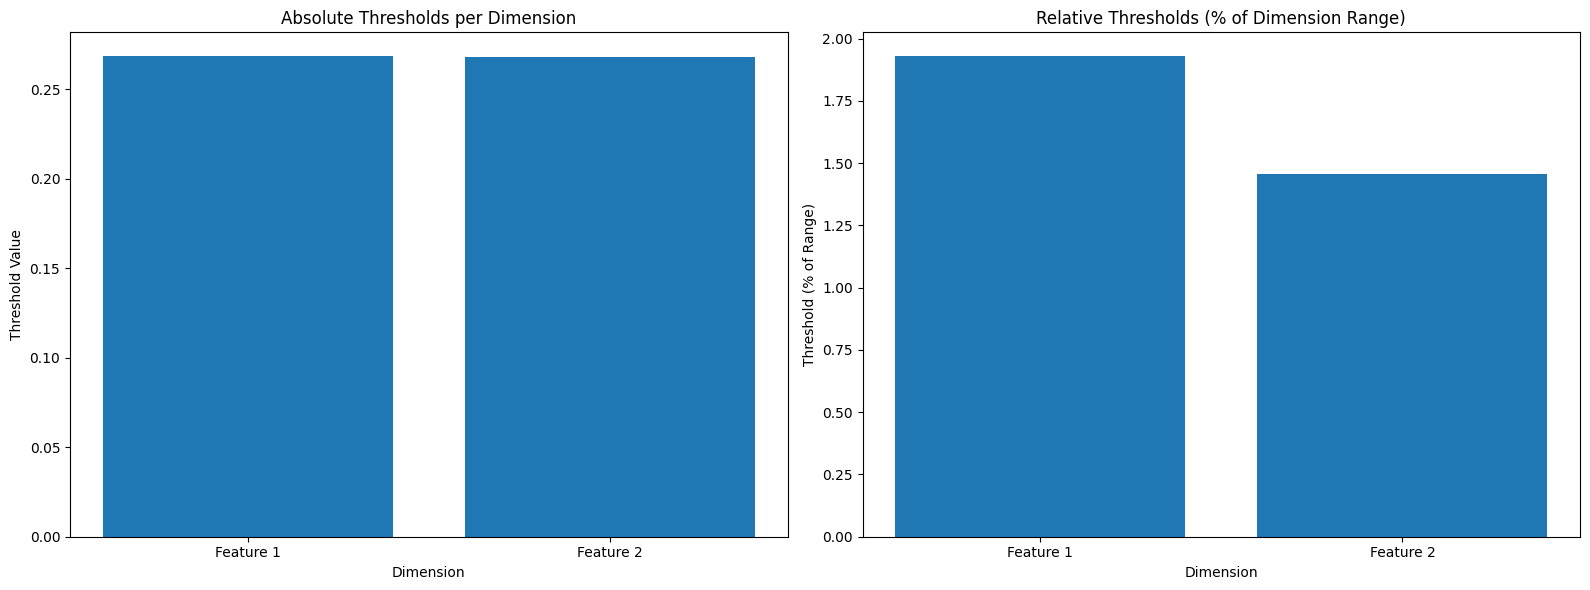

In [8]:
# Visualize the thresholds
feature_names = [f'Feature {i+1}' for i in range(X.shape[1])]

# Calculate data ranges for context
data_min = np.min(X, axis=0)
data_max = np.max(X, axis=0)
data_range = data_max - data_min

# Calculate relative thresholds (as percentage of data range)
relative_thresholds = thresholds / data_range * 100

# Create a DataFrame for easier plotting
threshold_df = pd.DataFrame({
    'Feature': feature_names,
    'Absolute Threshold': thresholds,
    'Relative Threshold (%)': relative_thresholds,
    'Data Range': data_range
})

print("Dimension-wise Thresholds:")
display(threshold_df)

# Plot threshold values
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Absolute thresholds
ax[0].bar(feature_names, thresholds)
ax[0].set_title('Absolute Thresholds per Dimension')
ax[0].set_ylabel('Threshold Value')
ax[0].set_xlabel('Dimension')

# Relative thresholds
ax[1].bar(feature_names, relative_thresholds)
ax[1].set_title('Relative Thresholds (% of Dimension Range)')
ax[1].set_ylabel('Threshold (% of Range)')
ax[1].set_xlabel('Dimension')

plt.tight_layout()
plt.show()

### 2.1 Threshold Selection Impact

Let's explore how different threshold percentiles affect the clustering results.

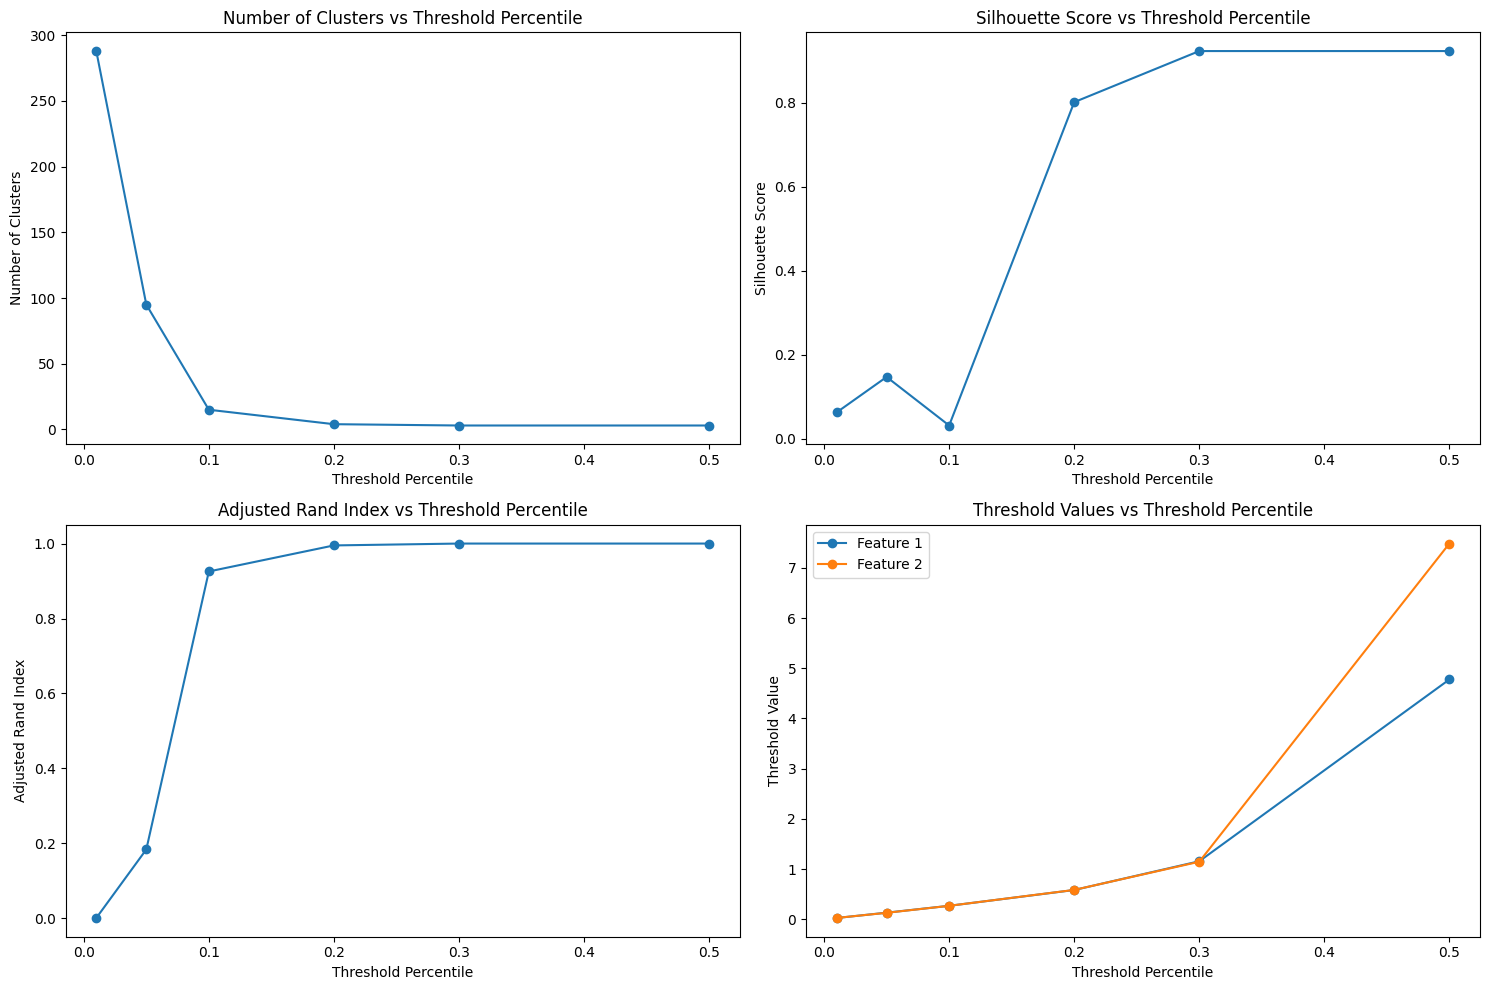

Optimal threshold percentile based on ARI: 0.3


In [9]:
# Test different threshold percentiles
percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
results = []

for percentile in percentiles:
    # Compute ETS clustering
    labels, thresholds = compute_ets_clustering(X, threshold_percentile=percentile)
    n_clusters = len(np.unique(labels))
    
    # Compute metrics if possible
    if n_clusters > 1:
        silhouette = silhouette_score(X, labels)
        ari = adjusted_rand_score(y_true, labels)
    else:
        silhouette = 0.0
        ari = 0.0
    
    # Store results
    results.append({
        'percentile': percentile,
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'ari': ari,
        'thresholds': thresholds
    })

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Number of clusters vs percentile
axs[0, 0].plot([r['percentile'] for r in results], [r['n_clusters'] for r in results], 'o-')
axs[0, 0].set_title('Number of Clusters vs Threshold Percentile')
axs[0, 0].set_xlabel('Threshold Percentile')
axs[0, 0].set_ylabel('Number of Clusters')

# Silhouette score vs percentile
axs[0, 1].plot([r['percentile'] for r in results], [r['silhouette'] for r in results], 'o-')
axs[0, 1].set_title('Silhouette Score vs Threshold Percentile')
axs[0, 1].set_xlabel('Threshold Percentile')
axs[0, 1].set_ylabel('Silhouette Score')

# ARI vs percentile
axs[1, 0].plot([r['percentile'] for r in results], [r['ari'] for r in results], 'o-')
axs[1, 0].set_title('Adjusted Rand Index vs Threshold Percentile')
axs[1, 0].set_xlabel('Threshold Percentile')
axs[1, 0].set_ylabel('Adjusted Rand Index')

# Thresholds vs percentile
thresholds_0 = [r['thresholds'][0] for r in results]
thresholds_1 = [r['thresholds'][1] for r in results]
axs[1, 1].plot([r['percentile'] for r in results], thresholds_0, 'o-', label='Feature 1')
axs[1, 1].plot([r['percentile'] for r in results], thresholds_1, 'o-', label='Feature 2')
axs[1, 1].set_title('Threshold Values vs Threshold Percentile')
axs[1, 1].set_xlabel('Threshold Percentile')
axs[1, 1].set_ylabel('Threshold Value')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Find optimal threshold percentile
best_percentile = max(results, key=lambda x: x['ari'])['percentile']
print(f"Optimal threshold percentile based on ARI: {best_percentile}")

## 3. ETS Explanation Capability

One of the most powerful features of ETS is its ability to explain *why* two points are in the same or different clusters. Let's explore this functionality.

In [10]:
# Use the clustering results from the optimal threshold percentile
optimal_ets = next(r for r in results if r['percentile'] == best_percentile)
optimal_labels = compute_ets_clustering(X, threshold_percentile=best_percentile)[0]
optimal_thresholds = optimal_ets['thresholds']

# Find pairs of points from same and different clusters
cluster_ids = np.unique(optimal_labels)

# Same cluster pair
cluster_id = cluster_ids[0]
points_in_cluster = np.where(optimal_labels == cluster_id)[0]
same_pair = (points_in_cluster[0], points_in_cluster[1])

# Different cluster pair
cluster_id1 = cluster_ids[0]
cluster_id2 = cluster_ids[1] if len(cluster_ids) > 1 else cluster_ids[0]
points_in_cluster1 = np.where(optimal_labels == cluster_id1)[0]
points_in_cluster2 = np.where(optimal_labels == cluster_id2)[0]
diff_pair = (points_in_cluster1[0], points_in_cluster2[0] if cluster_id1 != cluster_id2 else points_in_cluster1[2])

# Generate explanations
same_explanation = explain_ets_similarity(
    X[same_pair[0]], 
    X[same_pair[1]], 
    optimal_thresholds,
    feature_names=feature_names
)

diff_explanation = explain_ets_similarity(
    X[diff_pair[0]], 
    X[diff_pair[1]], 
    optimal_thresholds,
    feature_names=feature_names
)

# Display explanations
print("Points in Same Cluster:")
print(f"Point 1: {X[same_pair[0]]}")
print(f"Point 2: {X[same_pair[1]]}")
print(f"Explanation: {same_explanation['is_similar'] and 'Similar' or 'Different'}")
print(f"Dimensions within threshold: {same_explanation['num_dimensions_within_threshold']}/{same_explanation['num_dimensions_compared']}")
print("\n")

print("Points in Different Clusters:")
print(f"Point 1: {X[diff_pair[0]]}")
print(f"Point 2: {X[diff_pair[1]]}")
print(f"Explanation: {diff_explanation['is_similar'] and 'Similar' or 'Different'}")
print(f"Dimensions within threshold: {diff_explanation['num_dimensions_within_threshold']}/{diff_explanation['num_dimensions_compared']}")
print(f"Distinguishing dimensions: {', '.join(diff_explanation['distinguishing_dimensions'])}")

Points in Same Cluster:
Point 1: [-1.71959122  9.39800349]
Point 2: [-2.74393482  9.28556615]
Explanation: Similar
Dimensions within threshold: 2/2


Points in Different Clusters:
Point 1: [-1.71959122  9.39800349]
Point 2: [4.89739647 2.23006266]
Explanation: Different
Dimensions within threshold: 0/2
Distinguishing dimensions: Feature 1, Feature 2


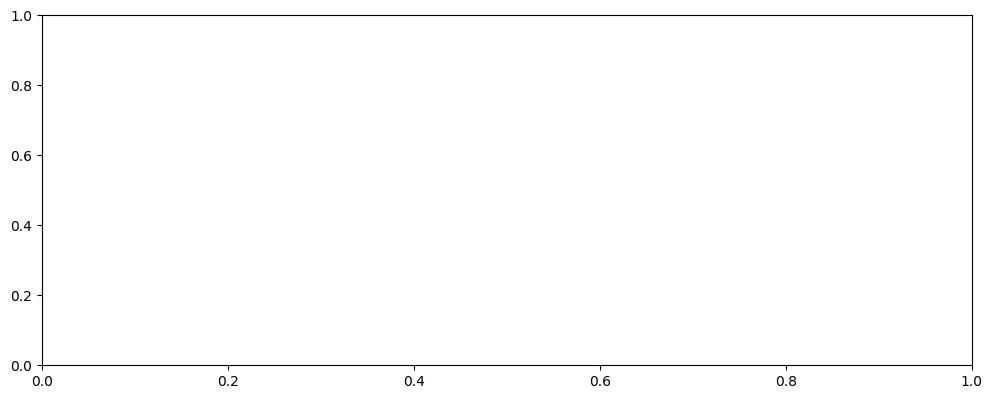

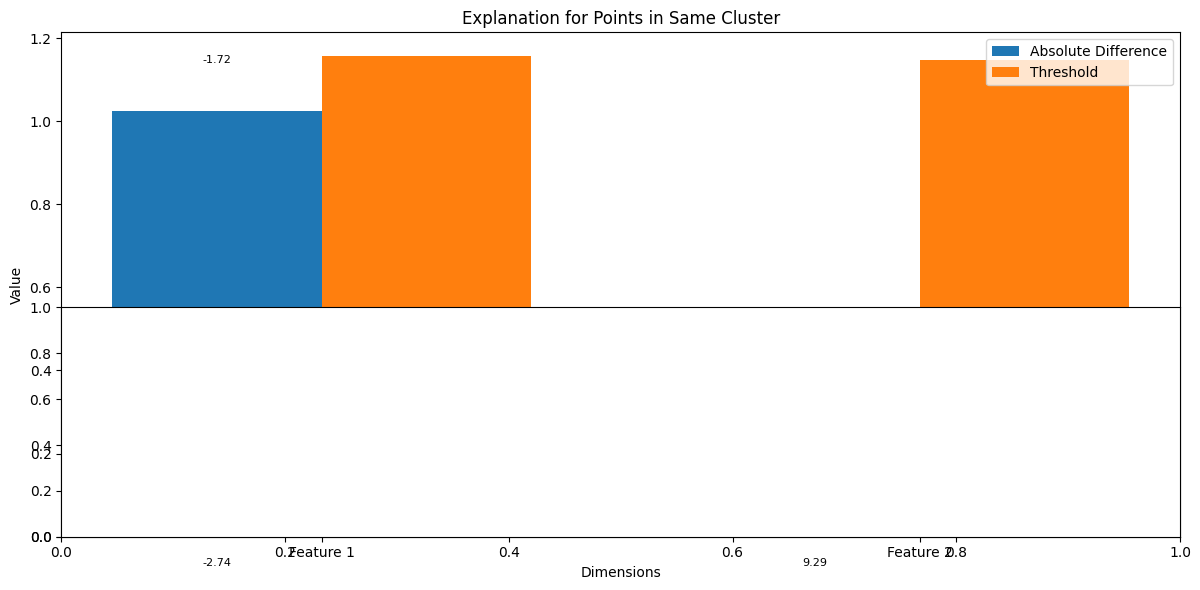

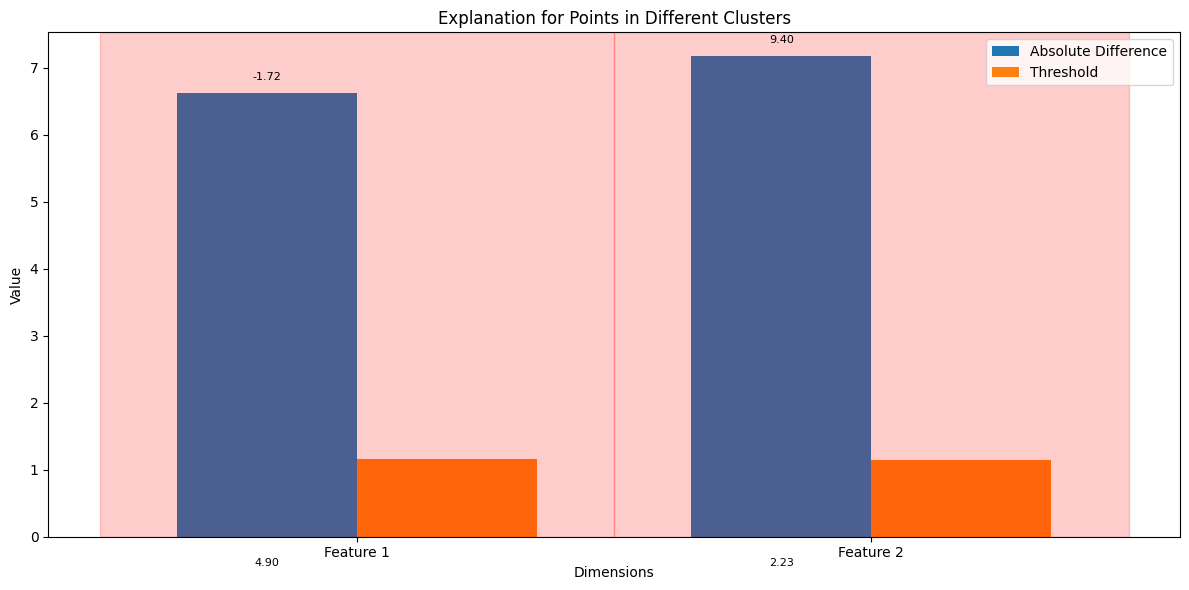

In [11]:
# Helper function to visualize explanation
def visualize_explanation(point1, point2, thresholds, feature_names=None):
    """Visualize the explanation for why two points are similar or different."""
    n_features = len(point1)
    
    # Set feature names if not provided
    if feature_names is None:
        feature_names = [f"Dimension {i}" for i in range(n_features)]
    
    # Compute dimension-wise absolute differences
    diffs = np.abs(point1 - point2)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create indices for the bars
    indices = np.arange(n_features)
    
    # Plot differences and thresholds
    width = 0.35
    ax.bar(indices - width/2, diffs, width, label="Absolute Difference")
    ax.bar(indices + width/2, thresholds, width, label="Threshold")
    
    # Highlight dimensions that exceed threshold
    for i in range(n_features):
        if diffs[i] > thresholds[i]:
            ax.axvspan(i - 0.5, i + 0.5, alpha=0.2, color='red')
    
    # Show whether points are similar
    is_similar = np.all(diffs <= thresholds)
    similarity_text = "Points are in the same cluster" if is_similar else "Points are in different clusters"
    ax.set_title(f"Dimension-wise Comparison: {similarity_text}")
    
    # Set labels
    ax.set_xlabel("Dimensions")
    ax.set_ylabel("Value")
    ax.set_xticks(indices)
    ax.set_xticklabels(feature_names)
    ax.legend()
    
    # Add values annotation
    for i in range(n_features):
        ax.annotate(f"{point1[i]:.2f}",
                  xy=(i - width/2, diffs[i] + 0.1),
                  xytext=(0, 3),
                  textcoords="offset points",
                  ha='center', va='bottom',
                  fontsize=8)
        ax.annotate(f"{point2[i]:.2f}",
                  xy=(i - width/2, 0),
                  xytext=(0, -15),
                  textcoords="offset points",
                  ha='center', va='top',
                  fontsize=8)
    
    plt.tight_layout()
    return fig

# Visualize same-cluster explanation
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
visualize_explanation(X[same_pair[0]], X[same_pair[1]], optimal_thresholds, feature_names)
plt.title("Explanation for Points in Same Cluster")
plt.tight_layout()

# Visualize different-cluster explanation
plt.subplot(2, 1, 2)
visualize_explanation(X[diff_pair[0]], X[diff_pair[1]], optimal_thresholds, feature_names)
plt.title("Explanation for Points in Different Clusters")
plt.tight_layout()
plt.show()

## 4. Working with Mixed-Scale Features

One of the key advantages of ETS is its ability to handle features with very different scales. Let's create a synthetic dataset with mixed scales and see how ETS performs.

In [12]:
# Generate synthetic data with mixed scales
def generate_mixed_scale_data(n_samples=300, n_clusters=3):
    # Feature scales with dramatically different ranges
    feature_scales = [
        1.0,       # Regular scale (0-1)
        100.0,     # Large scale (0-100)
        0.01,      # Small scale (0-0.01)
        10.0,      # Medium scale (0-10)
    ]
    
    # Generate data with these mixed scales
    X, y = generate_synthetic_data(
        n_samples=n_samples,
        n_clusters=n_clusters,
        n_features=len(feature_scales),
        cluster_std=0.2  # Keep clusters tight for this example
    )
    
    # Apply the scales
    for j in range(X.shape[1]):
        X[:, j] *= feature_scales[j]
    
    return X, y, feature_scales

# Generate mixed-scale data
X_mixed, y_mixed, feature_scales = generate_mixed_scale_data(n_samples=300, n_clusters=3)

# Display scale information
print("Feature Scales:")
for i, scale in enumerate(feature_scales):
    print(f"Feature {i+1}: {scale}")

# Show data ranges
data_min = np.min(X_mixed, axis=0)
data_max = np.max(X_mixed, axis=0)
data_range = data_max - data_min

print("\nData Ranges:")
for i in range(X_mixed.shape[1]):
    print(f"Feature {i+1}: {data_min[i]:.3f} to {data_max[i]:.3f} (range: {data_range[i]:.3f})")

Feature Scales:
Feature 1: 1.0
Feature 2: 100.0
Feature 3: 0.01
Feature 4: 10.0

Data Ranges:
Feature 1: -7.368 to 2.149 (range: 9.516)
Feature 2: -357.086 to 224.493 (range: 581.579)
Feature 3: -0.069 to 0.006 (range: 0.075)
Feature 4: 16.448 to 94.443 (range: 77.995)


Computing dimension thresholds...
Using thresholds with mean: 3.25902, min: 0.00104, max: 11.79093
Computing similarity matrix for 300 samples with batch size 1000
Similarity matrix computation completed in 0.01s
Finding connected components...
Found 194 clusters
Cluster sizes: min=1, max=21, mean=1.5
ETS ARI vs true labels: 0.044
K-means (raw data) ARI vs true labels: 0.980
K-means (scaled data) ARI vs true labels: 1.000

Thresholds Relative to Feature Scales:


,Feature,Feature Scale,Data Range,Absolute Threshold,Relative Threshold (%)
0,Feature 1,1.00,9.516025,0.101607,1.067749
1,Feature 2,100.00,581.578926,11.790934,2.027400
2,Feature 3,0.01,0.074594,0.001041,1.395570
3,Feature 4,10.00,77.994521,1.142484,1.464827


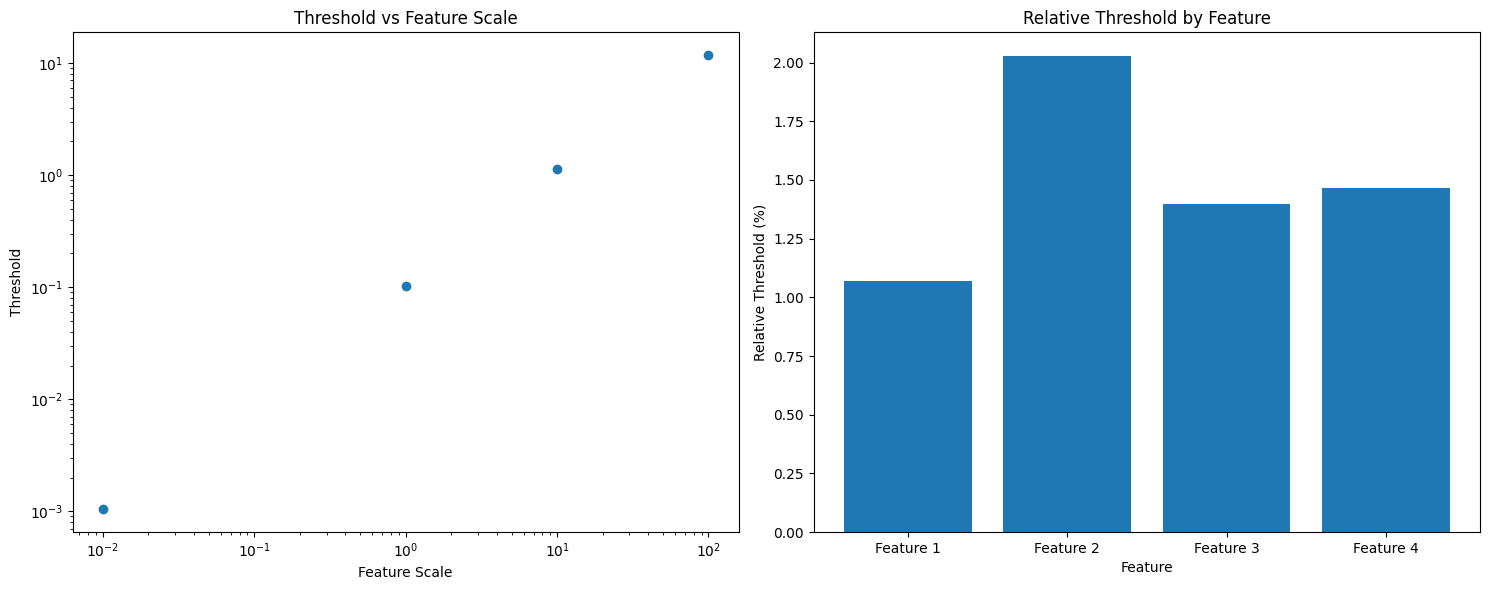

In [13]:
# Run ETS clustering on mixed-scale data
mixed_labels, mixed_thresholds = compute_ets_clustering(
    X_mixed,
    threshold_percentile=0.1,
    verbose=True
)

# Run k-means for comparison
# K-means is sensitive to scale, so we'll also run it on normalized data
kmeans_raw = KMeans(n_clusters=3, random_state=42)
kmeans_raw_labels = kmeans_raw.fit_predict(X_mixed)

# Normalize data for k-means
scaler = StandardScaler()
X_mixed_scaled = scaler.fit_transform(X_mixed)
kmeans_scaled = KMeans(n_clusters=3, random_state=42)
kmeans_scaled_labels = kmeans_scaled.fit_predict(X_mixed_scaled)

# Compare results
ari_ets = adjusted_rand_score(y_mixed, mixed_labels)
ari_kmeans_raw = adjusted_rand_score(y_mixed, kmeans_raw_labels)
ari_kmeans_scaled = adjusted_rand_score(y_mixed, kmeans_scaled_labels)

print(f"ETS ARI vs true labels: {ari_ets:.3f}")
print(f"K-means (raw data) ARI vs true labels: {ari_kmeans_raw:.3f}")
print(f"K-means (scaled data) ARI vs true labels: {ari_kmeans_scaled:.3f}")

# Visualize thresholds relative to data scales
mixed_feature_names = [f'Feature {i+1}' for i in range(X_mixed.shape[1])]

# Calculate relative thresholds (as percentage of data range)
relative_thresholds = mixed_thresholds / data_range * 100

# Create a DataFrame for easier display
threshold_scale_df = pd.DataFrame({
    'Feature': mixed_feature_names,
    'Feature Scale': feature_scales,
    'Data Range': data_range,
    'Absolute Threshold': mixed_thresholds,
    'Relative Threshold (%)': relative_thresholds
})

print("\nThresholds Relative to Feature Scales:")
display(threshold_scale_df)

# Plot threshold adaptation
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Feature scale vs threshold
axs[0].scatter(feature_scales, mixed_thresholds)
axs[0].set_title('Threshold vs Feature Scale')
axs[0].set_xlabel('Feature Scale')
axs[0].set_ylabel('Threshold')
axs[0].set_xscale('log')
axs[0].set_yscale('log')

# Feature vs relative threshold
axs[1].bar(mixed_feature_names, relative_thresholds)
axs[1].set_title('Relative Threshold by Feature')
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('Relative Threshold (%)')

plt.tight_layout()
plt.show()

## 5. Real-World Example: Titanic Dataset

Let's apply ETS to a real-world dataset - the Titanic passenger data. We'll use it to identify natural clusters of passengers and explain their characteristics.

In [14]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

# Select and preprocess features
# We'll use a subset of features for simplicity
features = ['age', 'fare', 'pclass', 'sex']

# Handle missing values
titanic_clean = titanic.copy()
titanic_clean['age'].fillna(titanic_clean['age'].median(), inplace=True)

# Encode categorical variables
titanic_clean['sex'] = titanic_clean['sex'].map({'male': 0, 'female': 1})

# Extract features and target
X_titanic = titanic_clean[features].values
y_titanic = titanic_clean['survived'].values

# Show dataset info
print("Titanic Dataset:")
print(f"Number of samples: {X_titanic.shape[0]}")
print(f"Number of features: {X_titanic.shape[1]}")
print(f"Features: {features}")

# Display feature statistics
titanic_stats = pd.DataFrame({
    'Feature': features,
    'Min': np.min(X_titanic, axis=0),
    'Max': np.max(X_titanic, axis=0),
    'Mean': np.mean(X_titanic, axis=0),
    'Std': np.std(X_titanic, axis=0)
})

display(titanic_stats)

Titanic Dataset:
Number of samples: 891
Number of features: 4
Features: ['age', 'fare', 'pclass', 'sex']


C:\Users\smiga\AppData\Local\Temp\ipykernel_12532\4019433831.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_clean['age'].fillna(titanic_clean['age'].median(), inplace=True)


,Feature,Min,Max,Mean,Std
0,age,0.42,80.0000,29.361582,13.012388
1,fare,0.00,512.3292,32.204208,49.665534
2,pclass,1.00,3.0000,2.308642,0.835602
3,sex,0.00,1.0000,0.352413,0.477722


In [19]:
# Run ETS clustering on Titanic data
titanic_labels, titanic_thresholds = compute_ets_clustering(
    X_titanic,
    threshold_percentile=0.5,
    verbose=True
)

# Evaluate clustering
n_clusters = len(np.unique(titanic_labels))
print(f"Number of clusters found: {n_clusters}")

if n_clusters > 1:
    silhouette = silhouette_score(X_titanic, titanic_labels)
    print(f"Silhouette score: {silhouette:.3f}")

# Compute cluster statistics
stats = compute_ets_statistics(X_titanic, titanic_labels, titanic_thresholds)

print("\nETS Clustering Statistics:")
print(f"Number of clusters: {stats['n_clusters']}")
print(f"Cluster sizes (min/max/mean): {stats['cluster_sizes']['min']}/{stats['cluster_sizes']['max']}/{stats['cluster_sizes']['mean']:.1f}")
print(f"Active dimensions per cluster (min/max/mean): {stats['active_dimensions']['min']}/{stats['active_dimensions']['max']}/{stats['active_dimensions']['mean']:.1f}")

# Sort dimensions by importance
importance = sorted([(int(k), v) for k, v in stats['dimension_importance'].items()], key=lambda x: x[1], reverse=True)
print("\nDimension Importance (which dimensions are most active in defining clusters):")
for dim, value in importance:
    print(f"{features[dim]}: {value:.3f}")

Computing dimension thresholds...
Using thresholds with mean: 7.85000, min: 1.00000, max: 17.40000
Computing similarity matrix for 891 samples with batch size 1000
Similarity matrix computation completed in 0.04s
Finding connected components...
Found 7 clusters
Cluster sizes: min=1, max=869, mean=127.3
Number of clusters found: 7
Silhouette score: 0.698

ETS Clustering Statistics:
Number of clusters: 7
Cluster sizes (min/max/mean): 1/869/127.3
Active dimensions per cluster (min/max/mean): 0/4/1.6

Dimension Importance (which dimensions are most active in defining clusters):
sex: 0.714
fare: 0.429
age: 0.286
pclass: 0.143


Cluster Statistics:


,cluster_id,count,percentage,survival_rate,age,fare,pclass,sex
0,0,869,97.530864,37.629459,29.391542,26.242438,2.341772,male
1,1,6,0.673401,66.666667,21.500000,260.211800,1.000000,female
2,2,3,0.336700,100.000000,35.333333,512.329200,1.000000,male
3,3,2,0.224467,50.000000,1.460000,151.550000,1.000000,male
4,4,1,0.112233,100.000000,50.000000,247.520800,1.000000,female
5,5,9,1.010101,66.666667,29.777778,219.710189,1.000000,female
6,6,1,0.112233,0.000000,64.000000,263.000000,1.000000,male


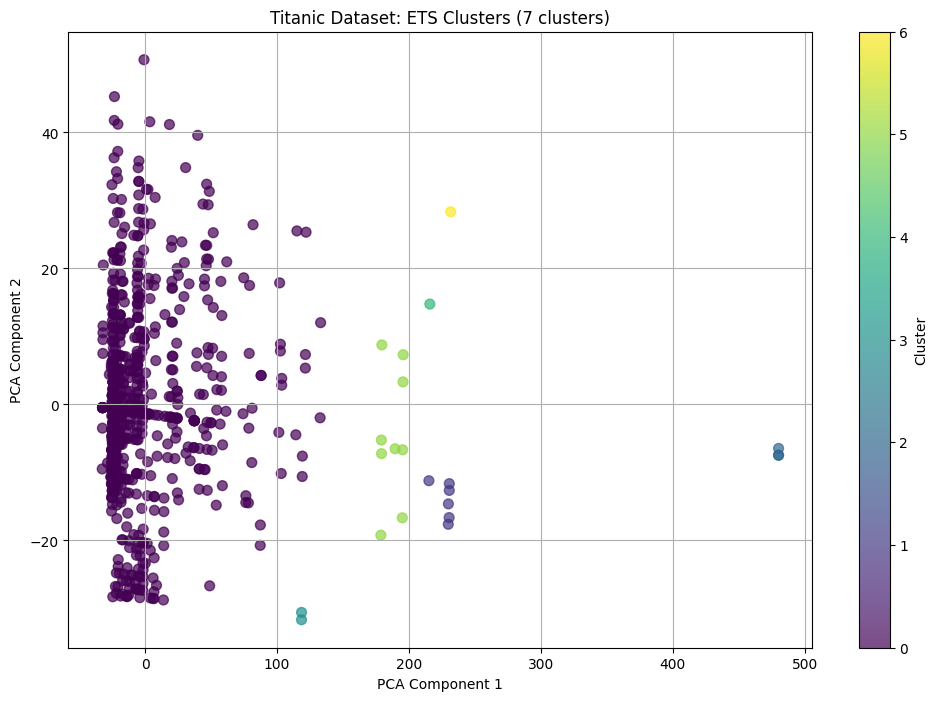

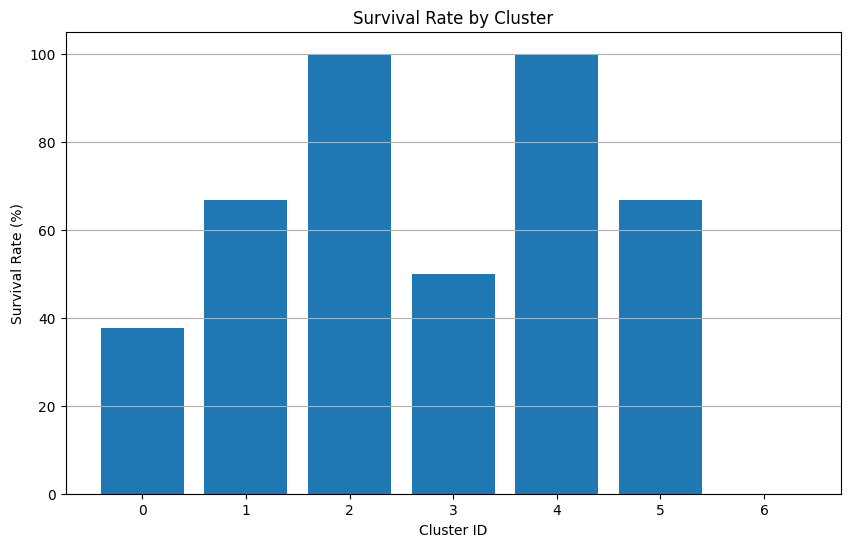

In [20]:
# Analyze clusters in terms of original features and survival rate
cluster_stats = []

for cluster_id in range(stats['n_clusters']):
    cluster_mask = (titanic_labels == cluster_id)
    cluster_data = X_titanic[cluster_mask]
    cluster_survival = y_titanic[cluster_mask]
    
    # Compute statistics
    feature_means = np.mean(cluster_data, axis=0)
    survival_rate = np.mean(cluster_survival)
    count = np.sum(cluster_mask)
    
    # Store statistics
    cluster_stats.append({
        'cluster_id': cluster_id,
        'count': count,
        'percentage': count / len(titanic_labels) * 100,
        'survival_rate': survival_rate * 100,
        **{features[i]: feature_means[i] for i in range(len(features))}
    })

# Convert to DataFrame
cluster_df = pd.DataFrame(cluster_stats)

# Decode sex back to string for clarity
cluster_df['sex'] = cluster_df['sex'].map(lambda x: 'female' if x > 0.5 else 'male')

print("Cluster Statistics:")
display(cluster_df)

# Visualize clusters in PCA space, colored by cluster
pca = PCA(n_components=2)
X_titanic_pca = pca.fit_transform(X_titanic)

plt.figure(figsize=(12, 8))
plt.scatter(X_titanic_pca[:, 0], X_titanic_pca[:, 1], c=titanic_labels, cmap='viridis', alpha=0.7, s=50)
plt.title(f'Titanic Dataset: ETS Clusters ({n_clusters} clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Visualize survival rate by cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_df['cluster_id'], cluster_df['survival_rate'])
plt.title('Survival Rate by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Survival Rate (%)')
plt.xticks(cluster_df['cluster_id'])
plt.grid(True, axis='y')
plt.show()

## 6. Integration with Transition Matrix Analysis

ETS clustering is particularly useful as part of Archetypal Path Analysis, where we track data points through multiple layers of a neural network. Let's demonstrate how to use ETS with transition matrices to analyze paths through a model.

In [18]:
# Import transition matrix utilities
from concept_fragmentation.analysis.transition_matrix import (
    compute_transition_matrix,
    compute_transition_entropy
)

# Generate multi-layer synthetic data
def generate_layered_data(n_samples=200, n_layers=3, n_features_per_layer=None, n_clusters_per_layer=None):
    """Generate synthetic data representing multiple layers of a neural network."""
    # Set defaults
    if n_features_per_layer is None:
        n_features_per_layer = [5, 8, 6]
    if n_clusters_per_layer is None:
        n_clusters_per_layer = [3, 4, 3]
    
    # Ensure we have the right number of layers
    n_layers = len(n_features_per_layer)
    assert len(n_clusters_per_layer) == n_layers, "Must provide cluster counts for all layers"
    
    # Generate data for each layer
    layers = {}
    true_clusters = {}
    
    for i in range(n_layers):
        layer_name = f"layer{i+1}"
        X, y = generate_synthetic_data(
            n_samples=n_samples,
            n_clusters=n_clusters_per_layer[i],
            n_features=n_features_per_layer[i],
            cluster_std=0.3
        )
        layers[layer_name] = X
        true_clusters[layer_name] = y
    
    return layers, true_clusters

# Generate layered data
layers, true_clusters = generate_layered_data(
    n_samples=200,
    n_features_per_layer=[4, 6, 5],
    n_clusters_per_layer=[3, 4, 3]
)

# Apply ETS clustering to each layer
ets_clusters = {}
threshold_percentile = 0.1

for layer_name, layer_data in layers.items():
    print(f"Clustering {layer_name}...")
    labels, thresholds = compute_ets_clustering(
        layer_data,
        threshold_percentile=threshold_percentile
    )
    ets_clusters[layer_name] = labels
    print(f"  Found {len(np.unique(labels))} clusters")

# Compute transition matrices between consecutive layers
transitions = {}
layer_names = sorted(layers.keys())

for i in range(len(layer_names)-1):
    source = layer_names[i]
    target = layer_names[i+1]
    transition_name = f"{source}_to_{target}"
    
    # Compute transition matrix
    transition_matrix = compute_transition_matrix(
        ets_clusters[source],
        ets_clusters[target]
    )
    
    transitions[transition_name] = transition_matrix
    
    # Compute transition entropy metrics
    entropy = compute_transition_entropy(transition_matrix)
    
    print(f"\nTransition: {transition_name}")
    print(f"Mean entropy: {entropy['mean_entropy']:.3f}")
    print(f"Normalized entropy: {entropy['normalized_entropy']:.3f}")
    print(f"Sparsity: {entropy['sparsity']:.3f}")

ModuleNotFoundError: No module named 'concept_fragmentation.analysis.transition_matrix'

In [17]:
# Plot transition matrices
for name, matrix in transitions.items():
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Transition Probability')
    plt.title(f'Transition Matrix: {name}')
    plt.xlabel('Target Cluster')
    plt.ylabel('Source Cluster')
    
    # Add text labels for significant transitions
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] > 0.2:  # Only label significant transitions
                plt.text(j, i, f'{matrix[i, j]:.2f}', 
                        ha='center', va='center', 
                        color='white' if matrix[i, j] > 0.5 else 'black')
    
    plt.tight_layout()
    plt.show()

# Extract and analyze paths
def extract_paths(layer_clusters):
    """Extract paths from layer clusters."""
    # Get ordered layer names
    layer_names = sorted(layer_clusters.keys())
    
    # Get number of samples
    n_samples = len(layer_clusters[layer_names[0]])
    
    # Create paths array
    n_layers = len(layer_names)
    paths = np.zeros((n_samples, n_layers), dtype=int)
    
    # Fill in paths
    for i, layer in enumerate(layer_names):
        paths[:, i] = layer_clusters[layer]
    
    return paths

# Extract paths
paths = extract_paths(ets_clusters)

# Count and display the most common paths
unique_paths, path_counts = np.unique(paths, axis=0, return_counts=True)
path_idx = np.argsort(-path_counts)

print(f"Found {len(unique_paths)} unique paths")
print("\nMost common paths:")
for i in range(min(5, len(unique_paths))):
    idx = path_idx[i]
    path = unique_paths[idx]
    count = path_counts[idx]
    percentage = count / len(paths) * 100
    print(f"Path {path}: {count} samples ({percentage:.1f}%)")

# Visualize path distribution
plt.figure(figsize=(10, 6))
plt.bar(range(min(10, len(unique_paths))), path_counts[path_idx[:10]] / len(paths) * 100)
plt.title('Top 10 Path Distribution')
plt.xlabel('Path Rank')
plt.ylabel('Percentage of Samples')
plt.grid(True, axis='y')
plt.show()

NameError: name 'transitions' is not defined

## 7. Best Practices and Tips

Here are some recommendations for using ETS effectively in your projects:

### 7.1 Selecting the Right Threshold Percentile

The threshold percentile is the most important parameter in ETS clustering. Here are some guidelines:

- **Low percentiles (0.01-0.05)**: Create more fine-grained clusters, good for detailed analysis
- **Medium percentiles (0.1-0.2)**: Balanced approach, works well for most datasets
- **High percentiles (0.3-0.5)**: Create broader clusters, good for high-level patterns

To find the optimal threshold, you can:
1. Start with a default of 0.1
2. Try a range of values and evaluate using silhouette score or ARI (if ground truth is available)
3. Visualize the clusters to ensure they make intuitive sense

### 7.2 Handling Large Datasets

ETS has built-in optimizations for large datasets:

- **Batch processing**: Use the `batch_size` parameter to control memory usage
- **Non-vectorized fallback**: Automatically used for very large similarity matrices
- **Sampling**: For extremely large datasets, consider using a representative sample first

### 7.3 Interpreting ETS Results

When analyzing ETS clustering results, consider:

1. **Dimension importance**: Which dimensions are most active in defining clusters?
2. **Cluster characteristics**: What are the typical values for each feature in each cluster?
3. **Pairwise explanations**: Use `explain_ets_similarity` to understand specific cluster assignments
4. **Cluster statistics**: Use `compute_ets_statistics` to get insights about cluster properties

### 7.4 Integration with Other Methods

ETS works well with other analysis techniques:

- **Dimensionality reduction**: Use PCA or UMAP for visualization after clustering
- **Transition analysis**: Combine with transition matrices for path analysis
- **Traditional clustering**: Compare results with k-means or DBSCAN for validation
- **Feature selection**: Use dimension importance to identify key features

## Summary

In this tutorial, we've explored Explainable Threshold Similarity (ETS) clustering, a method that provides transparent, dimension-wise cluster definitions. Key takeaways:

1. ETS automatically adapts to different feature scales without preprocessing
2. The threshold percentile parameter controls the granularity of clustering
3. ETS provides detailed explanations of why points belong to the same or different clusters
4. It integrates well with transition matrix analysis for multi-layer path tracking
5. The method provides statistical insights about cluster characteristics and feature importance

ETS is particularly valuable for interpretability tasks, where understanding why models cluster data in a certain way is as important as the clustering itself.